In [1]:
import pandas as pd
import xgboost as xgb
import numpy as np
import shap
import matplotlib.pyplot as plt
import boosting_library_mra as bl

In [2]:
focus_benfs = ['Flexible spending account','Vision and dental healthcare','Paid parental leave',
               'On-site daycare facility','Reimbursed daycare', 'Stock or equity options',
               'Flexible working hours','Pet-friendly']

In [3]:
focus_benfs2 = ['Flexible spending account','Vision and dental healthcare','Paid parental leave',
                'On-site daycare facility', 'Paid time off','Reimbursed daycare','Stock or equity options',
                'Easy access to public transportation','Flexible working hours','Pet-friendly',
                'Employee events','On-site fitness center','Free snacks and drinks']

In [4]:
# USE THIS TO CREATE AGGREGATES FOR lEADERSHIP/EMPLOYEE!
#new_data.loc[:,new_data.columns.str.contains('Leadership')].loc[:,new_data.loc[:,new_data.columns.str.contains('Leadership')].columns.str.contains('Company Culture')].mean(axis=1)

In [5]:
full_table_df = pd.read_csv('NEW_CATEGORIZED_DATA_060922.csv',index_col=0)

In [6]:
from scipy.stats import pearsonr
import numpy as np

In [7]:
rho = full_table_df.corr()
pval = full_table_df.corr(method=lambda x, y: pearsonr(x, y)[1]) - np.eye(*rho.shape)
p = pval.applymap(lambda x: ''.join(['*' for t in [.05, .01, .001] if x<=t]))
rho.round(2).astype(str) + p

An input array is constant; the correlation coefficent is not defined.


,fyear,GVKEY,datadate,act,at,bkvlps,capx,ceq,csho,cstk,...,providedfood**-_Leadership,cafeteria**-_Freelancer,food**-_Freelancer,fitness**-_Freelancer,discount**-_Freelancer,car**-_Freelancer,events**-_Freelancer,dogs**-_Freelancer,fitnesscenter**-_Freelancer,providedfood**-_Freelancer
fyear,1.0***,0.01,1.0***,0.11***,0.04**,-0.03,0.06***,0.07***,-0.0,0.02,...,-0.02,-0.08,-0.13,-0.11,0.11,-0.07,0.04,0.05,-0.09,0.13
GVKEY,0.01,1.0***,-0.0,-0.11***,-0.07***,-0.01,-0.13***,-0.11***,-0.15***,-0.12***,...,0.09,-0.12,-0.17,-0.22,-0.16,-0.14,-0.14,-0.09,-0.15,0.04
datadate,1.0***,-0.0,1.0***,0.1***,0.03*,-0.03,0.05***,0.06***,-0.01,0.01,...,-0.05,-0.19,-0.19,-0.19,0.06,-0.12,-0.1,0.01,-0.14,0.05
act,0.11***,-0.11***,0.1***,1.0***,0.79***,0.15***,0.58***,0.73***,0.7***,0.23***,...,0.1,0.02,-0.1,0.14,-0.16,-0.03,0.14,-0.09,-0.06,-0.08
at,0.04**,-0.07***,0.03*,0.79***,1.0***,0.02,0.2***,0.78***,0.56***,0.19***,...,0.05,0.23,-0.04,-0.04,-0.12,0.41**,0.19,-0.02,-0.03,0.3*
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
car**-_Freelancer,-0.07,-0.14,-0.12,-0.03,0.41**,-0.01,0.04,0.32*,0.42***,-0.07,...,-0.13,0.51***,0.19,0.33*,0.22,1.0***,0.46***,0.58***,0.25,0.48***
events**-_Freelancer,0.04,-0.14,-0.1,0.14,0.19,-0.11,0.19,0.15,0.3*,0.13,...,-0.03,0.42***,0.36**,0.62***,0.34**,0.46***,1.0***,0.31*,0.18,0.25
dogs**-_Freelancer,0.05,-0.09,0.01,-0.09,-0.02,-0.12,0.0,-0.03,0.15,-0.02,...,-0.06,0.31*,0.42***,0.37**,0.28*,0.58***,0.31*,1.0***,0.06,-0.06
fitnesscenter**-_Freelancer,-0.09,-0.15,-0.14,-0.06,-0.03,-0.09,0.19,-0.05,0.13,0.01,...,-0.11,0.53***,0.15,0.43***,0.3*,0.25,0.18,0.06,1.0***,0.12


In [8]:
len(full_table_df)

5353

In [9]:
#Create leadership df
leadership_df = pd.concat([full_table_df.iloc[:,:102],full_table_df.loc[:,full_table_df.columns.str.contains('Leadership')]],axis=1)

temp_list = list(leadership_df.iloc[:,102:120].columns.str.split('*'))

vars_list = [item for [item,_,_] in temp_list]

variable_names = ['contributionplan','definedcontribution','flexiblespending','healthcarenetwork','housingrelocation','lifeinsurance',
                   'maternity','officelocation','onsitedaycare','paidtimeoff','parking','reimburseddaycare','shares','telcoarrangements',
                   'transportation','tuition','workhours','cafeteria','car','discount','dogs','events','fitness','fitnesscenter','food','providedfood']

vars_list = vars_list + variable_names

for item in vars_list:
    leadership_df[item] = leadership_df.loc[:,leadership_df.columns.str.contains(item)].mean(axis=1)

leadership_df.drop(leadership_df.columns[102:234],axis=1,inplace=True)

In [10]:
# Create Employee_df
employee_df = pd.concat([full_table_df.iloc[:,:102],full_table_df.loc[:,full_table_df.columns.str.contains('Employee')]],axis=1)

temp_list = list(employee_df.iloc[:,102:120].columns.str.split('*'))

vars_list = [item for [item,_,_] in temp_list]

variable_names = ['contributionplan','definedcontribution','flexiblespending','healthcarenetwork','housingrelocation','lifeinsurance',
                   'maternity','officelocation','onsitedaycare','paidtimeoff','parking','reimburseddaycare','shares','telcoarrangements',
                   'transportation','tuition','workhours','cafeteria','car','discount','dogs','events','fitness','fitnesscenter','food','providedfood']

vars_list = vars_list + variable_names

for item in vars_list:
    employee_df[item] = employee_df.loc[:,employee_df.columns.str.contains(item)].mean(axis=1)

employee_df.drop(employee_df.columns[102:234],axis=1,inplace=True)

In [13]:
temp_df = pd.DataFrame()

In [14]:
temp_df['Leaders'] = leadership_df.iloc[:,-26:].mean()

In [15]:
temp_df['Employees'] = employee_df.iloc[:,-26:].mean()

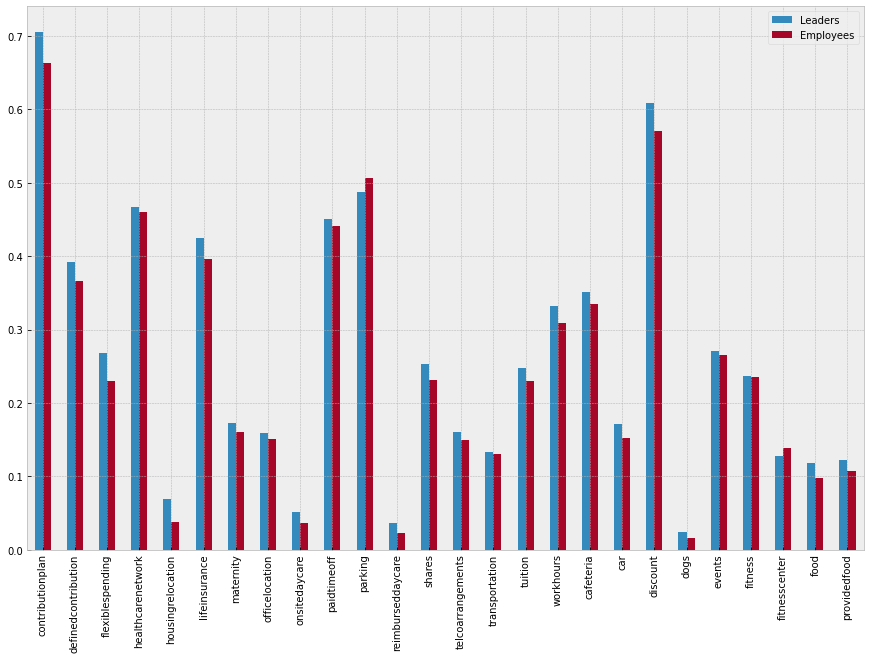

In [16]:
temp_df.plot.bar(figsize=(15,10))
plt.show()

In [17]:
# Employee industry difference
ind_df = pd.DataFrame()
for item in employee_df.iterrows():
    new_row = pd.DataFrame(item[1][120:146].astype(float)-employee_df.groupby('ind').mean().iloc[item[1]['ind']-1,116:142])
    ind_df = pd.concat([ind_df,new_row.T],ignore_index=True)
employee_df[ind_df.columns] = ind_df

In [18]:
# Leadership industry difference
ind_df = pd.DataFrame()
for item in leadership_df.iterrows():
    new_row = pd.DataFrame(item[1][120:146].astype(float)-leadership_df.groupby('ind').mean().iloc[item[1]['ind']-1,116:142])
    ind_df = pd.concat([ind_df,new_row.T],ignore_index=True)
leadership_df[ind_df.columns] = ind_df

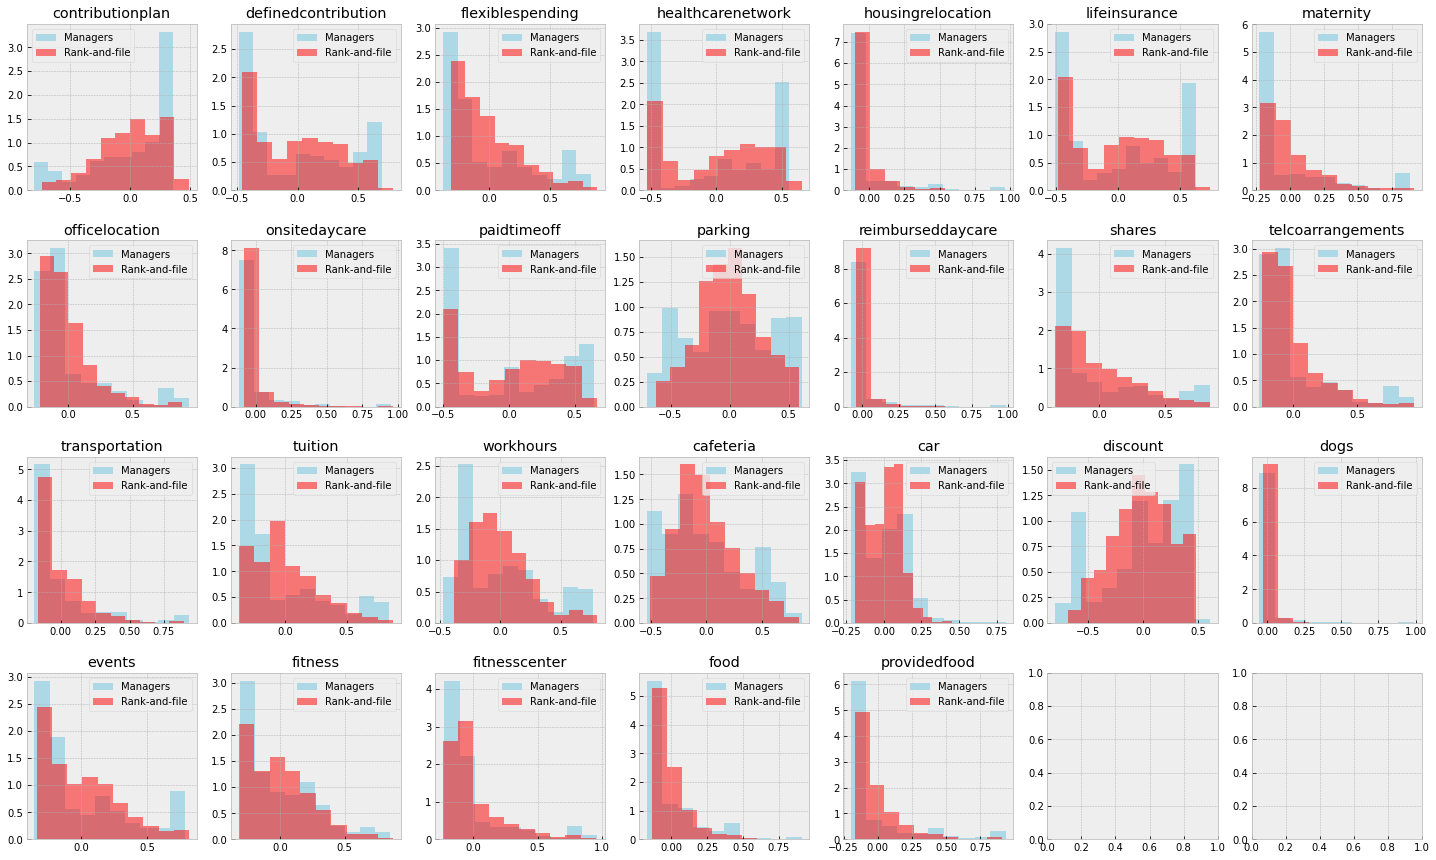

In [19]:
fig,axs = plt.subplots(4,7,figsize=(25,15))
for ax,item in zip(axs.flat,leadership_df.iloc[:,-26:].columns):
    ax.hist(leadership_df[item],alpha=1.0,label='Managers',density=True,color='lightblue')
    ax.hist(employee_df[item],alpha=0.5,label='Rank-and-file',density=True,color='red')
    ax.set_title(item)
    ax.legend()
plt.subplots_adjust(hspace=0.3)
plt.show()

In [20]:
full_table_df = employee_df

In [21]:
full_table_df = full_table_df.loc[~full_table_df['tobin'].isna()]

In [22]:
full_table_df = full_table_df[full_table_df['fyear'] > 2013]

In [23]:
full_table_df['tobin'] = full_table_df['tobin'].clip(lower=full_table_df['tobin'].quantile(0.01), upper=full_table_df['tobin'].quantile(0.99))

In [24]:
# NO MORE ROA
firm_controls = ['at','lvg','rd_int','cap_int','optvol','age']

In [25]:
full_table_df['rd_int'] = 100*full_table_df['rd_int']
full_table_df['cap_int'] = 100*full_table_df['cap_int']
full_table_df['roa'] = 100*full_table_df['roa']

In [26]:
# WINSORIZE
full_table_df[firm_controls] = full_table_df[firm_controls].clip(lower=full_table_df[firm_controls].quantile(0.01),
                                                               upper=full_table_df[firm_controls].quantile(0.99), axis = 1)

Downcasting integer-dtype results in .where is deprecated and will change in a future version. To retain the old behavior, explicitly cast the results to the desired dtype.


In [27]:
full_table_df.rename({'contributionplan':'401(k)',
                      'definedcontribution':'401(k) Company match', 'flexiblespending':'Flexible spending account',
                      'healthcarenetwork':'Vision and dental healthcare','housingrelocation':'Relocation allowance',
                      'lifeinsurance':'Life insurance', 'maternity':'Paid parental leave',
                      'officelocation':'Desirable office location','onsitedaycare':'On-site daycare facility',
                      'paidtimeoff':'Paid time off', 'parking':'Parking','reimburseddaycare':'Reimbursed daycare',
                      'shares':'Stock or equity options','telcoarrangements':'Ability to work remotely',
                      'transportation':'Easy access to public transportation','tuition':'Tuition assistance',
                      'workhours':'Flexible working hours','cafeteria':'On-site cafeteria','car':'Vehicle allowance',
                      'discount':'Employee discounts','dogs':'Pet-friendly','events':'Employee events',
                      'fitness':'Health and wellness programs','fitnesscenter':'On-site fitness center',
                      'food':'Free snacks and drinks', 'providedfood':'Free meals'},inplace=True,axis=1)

In [28]:
pred_vars = list(full_table_df.columns[-26:])

In [29]:
full_table_df[pred_vars] = full_table_df[pred_vars].clip(lower=full_table_df[pred_vars].quantile(0.01),
                                                               upper=full_table_df[pred_vars].quantile(0.99), axis = 1)

In [30]:
# SIC to 2-digit
temp = full_table_df['sic'].values/100
sic2dig = [int(i) for i in np.floor(temp)]
full_table_df['sic2dig'] = sic2dig

In [31]:
control_vars = firm_controls + ['sic2dig']

In [32]:
full_table_df.reset_index(drop=True,inplace=True)

In [33]:
y_df = full_table_df['tobin']
x_employee_df = full_table_df[pred_vars+control_vars]

In [34]:
dtrain = xgb.DMatrix(x_employee_df, label=y_df, nthread = -1)

In [35]:
m_depth = 6
eta = 0.1
ssample = 0.8
col_tree = 0.6
m_child_w = 1
gam = 0.
param = {'max_depth': m_depth, 'eta': eta, 'subsample': ssample, 'colsample_bytree': col_tree, 'min_child_weight' : m_child_w, 'gamma' : gam}

In [32]:
#temp = xgb.cv(param,dtrain,num_boost_round=1000,nfold=5,seed=10)

In [33]:
#plt.plot(temp['test-rmse-mean'][150:1500])

In [34]:
b_rounds = 500

In [35]:
bst = xgb.train(param,dtrain,num_boost_round=b_rounds)

In [36]:
j=0
shap.initjs()

In [37]:
explainerXGB = shap.TreeExplainer(bst)
shap_values_employee = explainerXGB.shap_values(x_employee_df,y_df)

In [38]:
shap_values_employee_df = pd.DataFrame(shap_values_employee,columns=x_employee_df.columns)

In [39]:
#shap_interactions_emp = explainerXGB.shap_interaction_values(x_employee_df,y_df)

In [40]:
import pickle

In [41]:
"""# Save dump files

fp = open('shap_interactions_emp.picdata','wb')
pickle.dump(shap_interactions,fp)
fp.close()"""

"# Save dump files\n\nfp = open('shap_interactions_emp.picdata','wb')\npickle.dump(shap_interactions,fp)\nfp.close()"

In [42]:
# Load dump files

fp = open('shap_interactions_emp.picdata','rb')
shap_interactions_emp = pickle.load(fp)
fp.close()

In [43]:
import seaborn as sns

In [44]:
# FOR THE PAPER

In [45]:
temp_np = np.mean(np.abs(shap_interactions_emp),axis=0)

In [46]:
#for i in range(temp_np.shape[1]):
#    temp_np[i,i] = 0

In [47]:
temp_df = pd.DataFrame(temp_np, columns=x_employee_df.columns,index=x_employee_df.columns)

In [48]:
temp_df.loc[focus_benfs,'at'].sort_values(ascending=False).to_clipboard()

In [49]:
temp_df.max(axis=None).sort_values(ascending=False)

In a future version, DataFrame.max(axis=None) will return a scalar max over the entire DataFrame. To retain the old behavior, use 'frame.max(axis=0)' or just 'frame.max()'


optvol                                  0.243047
rd_int                                  0.242394
lvg                                     0.216180
cap_int                                 0.165244
at                                      0.122009
sic2dig                                 0.071091
age                                     0.044858
On-site daycare facility                0.040367
Flexible spending account               0.038372
Pet-friendly                            0.034002
Free snacks and drinks                  0.033848
Reimbursed daycare                      0.033540
On-site cafeteria                       0.029308
Stock or equity options                 0.027816
Health and wellness programs            0.023108
Vision and dental healthcare            0.021917
Easy access to public transportation    0.021403
401(k)                                  0.020872
Paid parental leave                     0.018199
Parking                                 0.018193
Relocation allowance

In [50]:
temp_results_df = pd.DataFrame()

In [51]:
temp_results_df['sum'] = temp_df.sum()
temp_results_df['max'] = temp_df.max()
temp_results_df['max_var'] = temp_df.idxmax()
temp_df.index = x_employee_df.columns

In [52]:
temp_results_df.replace({'at':'Total assets','lvg':'Leverage','cap_int':'Capital intensity',
                        'rd_int':'Research intensity','optvol':'Implied volatility',
                        'age':'Firm age','sic2dic':'Industry'},inplace=True)
temp_results_df.rename({'at':'Total assets','lvg':'Leverage','cap_int':'Capital intensity',
                        'rd_int':'Research intensity','optvol':'Implied volatility',
                        'age':'Firm age','sic2dic':'Industry'},inplace=True)

In [53]:
temp_results_df['Tobin\'s Q'] = temp_results_df['max_var'] + '\n(' + (100*temp_results_df['max']).round(2).astype(str) + ')'

In [54]:
temp_results_df['Tobin\'s Q (relative)'] = temp_results_df['max_var'] + '\n(' + (100*temp_results_df['max']/np.mean(y_df)).round(2).astype(str) + ' %)'

In [55]:
temp_results_df.iloc[0:26,:][['Tobin\'s Q (relative)']].to_clipboard()

In [56]:
# ADDITIONAL ANALYSES

In [57]:
temp_df = pd.DataFrame()
temp_df['direct'] = temp_np.diagonal()
temp_df['interction'] = (temp_np.sum(axis=0)-temp_np.diagonal())
temp_df['var'] = x_employee_df.columns[0:33]

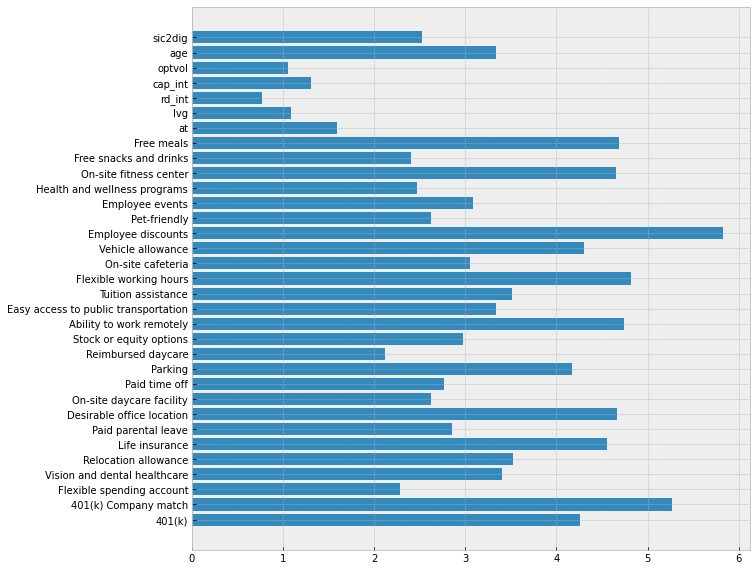

In [58]:
# Direct - interaction -ratio
ratio_np = (temp_np.sum(axis=0)-temp_np.diagonal())/temp_np.diagonal()
plt.figure(figsize=(10,10))
plt.barh(x_employee_df.columns[0:33], ratio_np)
plt.show()

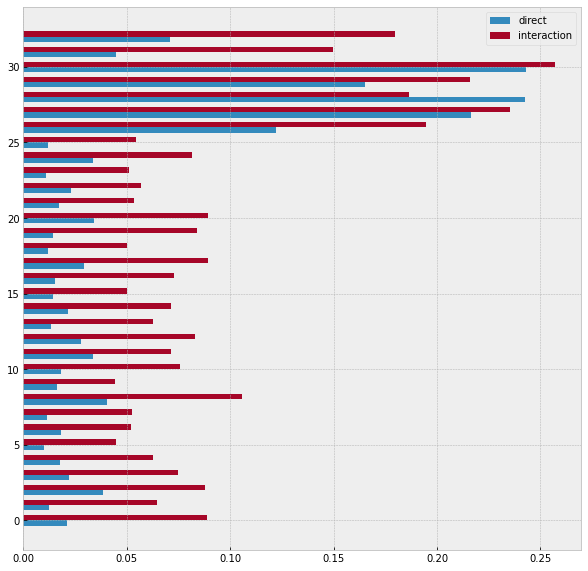

In [59]:
x = np.arange(len(temp_df))
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(10,10))
rects1 = ax.barh(x - width/2, temp_df['direct'], width, label='direct')
rects2 = ax.barh(x + width/2, temp_df['interction'], width, label='interaction')
#ax.set_yticks(x, x_employee_df.columns[0:33])
ax.legend()
plt.show()

In [60]:
inter_df = pd.DataFrame(temp_np,index=x_employee_df.columns,columns=x_employee_df.columns[0:33])

In [61]:
temp2_df = inter_df.round(4)*100

In [62]:
temp2_df['direct'] = np.append(temp2_df.to_numpy().diagonal(),np.zeros(0))

In [63]:
temp2_df.to_clipboard()

<AxesSubplot:>

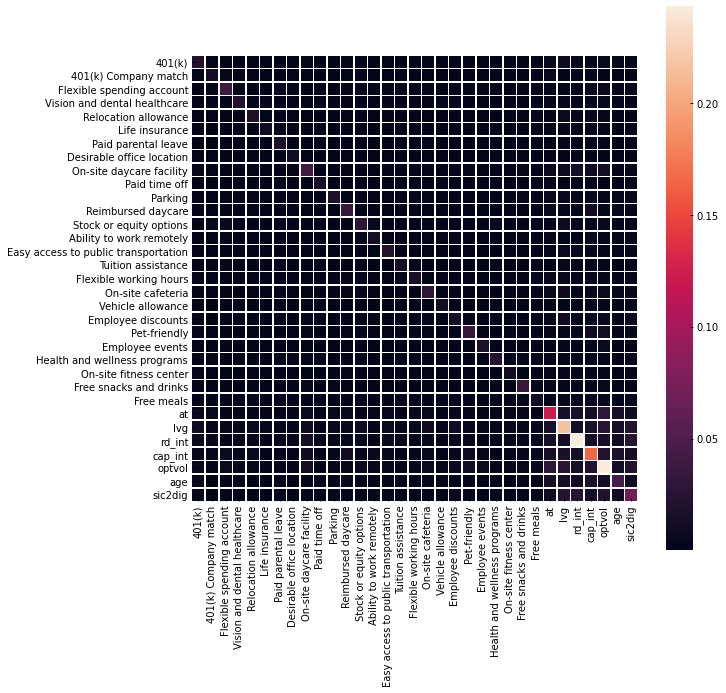

In [64]:
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(temp_np,linewidths=.5,
            square=True,xticklabels=x_employee_df.columns[0:33],yticklabels=x_employee_df.columns[0:33])

Pass the following variables as keyword args: x, y, hue. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


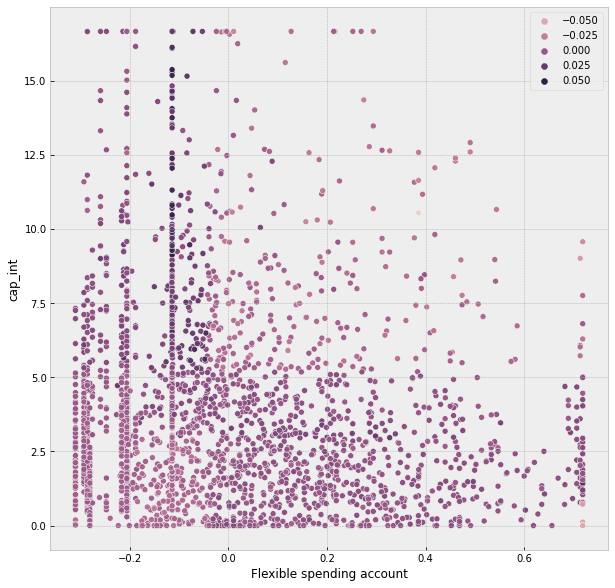

In [65]:
fig, ax = plt.subplots(figsize=(10,10))
sns.scatterplot(x_employee_df.iloc[:,2],x_employee_df.iloc[:,29],shap_interactions_emp[:,2,29],ax=ax)
plt.show()

Pass the following variables as keyword args: x, y, hue. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


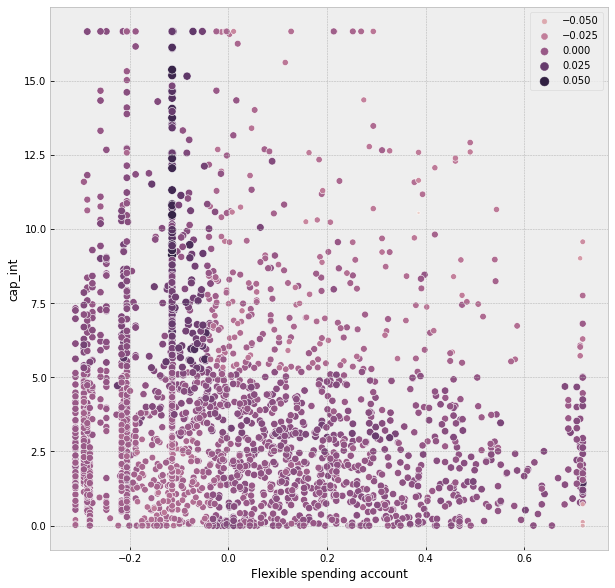

In [66]:
fig, ax = plt.subplots(figsize=(10,10))
sns.color_palette("mako", as_cmap=True)
sns.scatterplot(x_employee_df.iloc[:,2],x_employee_df.iloc[:,29],shap_interactions_emp[:,2,29],size=shap_interactions_emp[:,2,29],sizes=(10,80),ax=ax,
                x_jitter=40,y_jitter=40)
plt.show()

In [67]:
for item in zip(range(0,33),x_employee_df.columns):
    print(item)

(0, '401(k)')
(1, '401(k) Company match')
(2, 'Flexible spending account')
(3, 'Vision and dental healthcare')
(4, 'Relocation allowance')
(5, 'Life insurance')
(6, 'Paid parental leave')
(7, 'Desirable office location')
(8, 'On-site daycare facility')
(9, 'Paid time off')
(10, 'Parking')
(11, 'Reimbursed daycare')
(12, 'Stock or equity options')
(13, 'Ability to work remotely')
(14, 'Easy access to public transportation')
(15, 'Tuition assistance')
(16, 'Flexible working hours')
(17, 'On-site cafeteria')
(18, 'Vehicle allowance')
(19, 'Employee discounts')
(20, 'Pet-friendly')
(21, 'Employee events')
(22, 'Health and wellness programs')
(23, 'On-site fitness center')
(24, 'Free snacks and drinks')
(25, 'Free meals')
(26, 'at')
(27, 'lvg')
(28, 'rd_int')
(29, 'cap_int')
(30, 'optvol')
(31, 'age')
(32, 'sic2dig')


Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


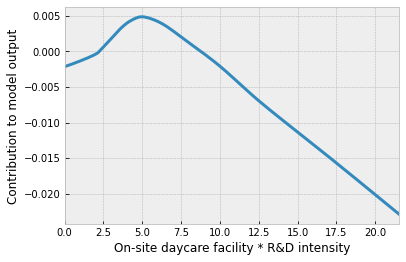

In [68]:
sns.regplot((x_employee_df.iloc[:,2]+1)*x_employee_df.iloc[:,29],shap_interactions_emp[:,2,29],lowess=True,scatter=False)
plt.xlabel('On-site daycare facility * R&D intensity')
plt.ylabel('Contribution to model output')
plt.show()

In [69]:
n_values = len(full_table_df)

In [70]:
"""bootstrap_samples_employee_df, bootstrap_shaps_employee_df = bl.calculate_bootstrap(full_table_df,pred_vars + control_vars,
                                                                  'tobin',param,'conm',n_values=n_values,
                                                                  metrics='mae',num_trees=b_rounds,boot_rounds=200,esr=100)"""

"bootstrap_samples_employee_df, bootstrap_shaps_employee_df = bl.calculate_bootstrap(full_table_df,pred_vars + control_vars,\n                                                                  'tobin',param,'conm',n_values=n_values,\n                                                                  metrics='mae',num_trees=b_rounds,boot_rounds=200,esr=100)"

In [71]:
import pickle

In [72]:
"""# Save dump files

fp = open('boots_samples_tob_emp.picdata','wb')
pickle.dump(bootstrap_samples_employee_df,fp)
fp.close()

fp = open('boots_shaps_tob_emp.picdata','wb')
pickle.dump(bootstrap_shaps_employee_df,fp)
fp.close()"""

"# Save dump files\n\nfp = open('boots_samples_tob_emp.picdata','wb')\npickle.dump(bootstrap_samples_employee_df,fp)\nfp.close()\n\nfp = open('boots_shaps_tob_emp.picdata','wb')\npickle.dump(bootstrap_shaps_employee_df,fp)\nfp.close()"

In [73]:
# Load dump files

fp = open('boots_samples_tob_emp.picdata','rb')
bootstrap_samples_employee_df = pickle.load(fp)
fp.close()

fp = open('boots_shaps_tob_emp.picdata','rb')
bootstrap_shaps_employee_df = pickle.load(fp)
fp.close()

In [36]:
# Leaders
full_table_df = leadership_df

full_table_df = full_table_df.loc[~full_table_df['tobin'].isna()]

full_table_df = full_table_df[full_table_df['fyear'] > 2013]

full_table_df['tobin'] = full_table_df['tobin'].clip(lower=full_table_df['tobin'].quantile(0.01), upper=full_table_df['tobin'].quantile(0.99))

firm_controls = ['at','lvg','rd_int','cap_int','optvol','age']

full_table_df['rd_int'] = 100*full_table_df['rd_int']
full_table_df['cap_int'] = 100*full_table_df['cap_int']
full_table_df['roa'] = 100*full_table_df['roa']

# WINSORIZE
full_table_df[firm_controls] = full_table_df[firm_controls].clip(lower=full_table_df[firm_controls].quantile(0.01),
                                                               upper=full_table_df[firm_controls].quantile(0.99), axis = 1)

full_table_df.rename({'contributionplan':'401(k)',
                      'definedcontribution':'401(k) Company match', 'flexiblespending':'Flexible spending account',
                      'healthcarenetwork':'Vision and dental healthcare','housingrelocation':'Relocation allowance',
                      'lifeinsurance':'Life insurance', 'maternity':'Paid parental leave',
                      'officelocation':'Desirable office location','onsitedaycare':'On-site daycare facility',
                      'paidtimeoff':'Paid time off', 'parking':'Parking','reimburseddaycare':'Reimbursed daycare',
                      'shares':'Stock or equity options','telcoarrangements':'Ability to work remotely',
                      'transportation':'Easy access to public transportation','tuition':'Tuition assistance',
                      'workhours':'Flexible working hours','cafeteria':'On-site cafeteria','car':'Vehicle allowance',
                      'discount':'Employee discounts','dogs':'Pet-friendly','events':'Employee events',
                      'fitness':'Health and wellness programs','fitnesscenter':'On-site fitness center',
                      'food':'Free snacks and drinks', 'providedfood':'Free meals'},inplace=True,axis=1)

pred_vars = list(full_table_df.columns[-26:])

full_table_df[pred_vars] = full_table_df[pred_vars].clip(lower=full_table_df[pred_vars].quantile(0.01),
                                                               upper=full_table_df[pred_vars].quantile(0.99), axis = 1)

# SIC to 2-digit
temp = full_table_df['sic'].values/100
sic2dig = [int(i) for i in np.floor(temp)]
full_table_df['sic2dig'] = sic2dig

control_vars = firm_controls + ['sic2dig']

full_table_df.reset_index(drop=True,inplace=True)

y_df = full_table_df['tobin']
x_leadership_df = full_table_df[pred_vars+control_vars]

Downcasting integer-dtype results in .where is deprecated and will change in a future version. To retain the old behavior, explicitly cast the results to the desired dtype.


In [75]:
# Leaders
dtrain = xgb.DMatrix(x_leadership_df, label=y_df, nthread = 1)

m_depth = 6
eta = 0.15
ssample = 0.8
col_tree = 0.6
m_child_w = 1
gam = 0.
param = {'max_depth': m_depth, 'eta': eta, 'subsample': ssample, 'colsample_bytree': col_tree, 'min_child_weight' : m_child_w, 'gamma' : gam}

#temp = xgb.cv(param,dtrain,num_boost_round=1000,nfold=5,seed=10)

In [76]:
#plt.plot(temp['test-rmse-mean'][150:1500])

In [77]:
b_rounds = 400

bst = xgb.train(param,dtrain,num_boost_round=b_rounds)

j=0
shap.initjs()

explainerXGB = shap.TreeExplainer(bst)
shap_values_leader = explainerXGB.shap_values(x_leadership_df,y_df)
shap_values_leader_df = pd.DataFrame(shap_values_leader,columns=x_leadership_df.columns)
n_values = len(full_table_df)

In [78]:
# INTERACTIONS

In [79]:
#shap_interactions_lead = explainerXGB.shap_interaction_values(x_leadership_df,y_df)

In [80]:
import pickle

In [81]:
"""# Save dump files

fp = open('shap_interactions_lead.picdata','wb')
pickle.dump(shap_interactions_lead,fp)
fp.close()"""

"# Save dump files\n\nfp = open('shap_interactions_lead.picdata','wb')\npickle.dump(shap_interactions_lead,fp)\nfp.close()"

In [82]:
# Load dump files

fp = open('shap_interactions_lead.picdata','rb')
shap_interactions_lead = pickle.load(fp)
fp.close()

In [83]:
# FOR THE PAPER

In [84]:
temp_np = np.mean(np.abs(shap_interactions_emp),axis=0)

In [85]:
for i in range(temp_np.shape[1]):
    temp_np[i,i] = 0

In [86]:
temp_df = pd.DataFrame(temp_np, columns=x_employee_df.columns,index=x_employee_df.columns)

In [87]:
temp_df.loc[focus_benfs,'at'].sort_values(ascending=False)

On-site daycare facility        0.007127
Flexible working hours          0.005703
Reimbursed daycare              0.005368
Pet-friendly                    0.004342
Vision and dental healthcare    0.003481
Flexible spending account       0.002968
Stock or equity options         0.002852
Paid parental leave             0.001951
Name: at, dtype: float32

In [88]:
temp_df.loc[:,'at'].sort_values(ascending=False)

optvol                                  0.029015
rd_int                                  0.016268
lvg                                     0.015475
age                                     0.014588
cap_int                                 0.014030
sic2dig                                 0.008857
On-site daycare facility                0.007127
On-site cafeteria                       0.005947
Flexible working hours                  0.005703
401(k) Company match                    0.005529
401(k)                                  0.005464
Reimbursed daycare                      0.005368
Parking                                 0.005273
Employee discounts                      0.004421
Pet-friendly                            0.004342
Free snacks and drinks                  0.004254
Easy access to public transportation    0.004030
Vision and dental healthcare            0.003481
Ability to work remotely                0.003309
On-site fitness center                  0.003240
Flexible spending ac

In [89]:
temp_results_df = pd.DataFrame()

In [90]:
temp_results_df['sum'] = temp_df.sum()
temp_results_df['max'] = temp_df.max()
temp_results_df['max_var'] = temp_df.idxmax()
temp_df.index = x_employee_df.columns

In [91]:
temp_results_df.replace({'at':'Total assets','lvg':'Leverage','cap_int':'Capital intensity',
                        'rd_int':'Research intensity','optvol':'Implied volatility',
                        'age':'Firm age','sic2dic':'Industry'},inplace=True)
temp_results_df.rename({'at':'Total assets','lvg':'Leverage','cap_int':'Capital intensity',
                        'rd_int':'Research intensity','optvol':'Implied volatility',
                        'age':'Firm age','sic2dic':'Industry'},inplace=True)

In [92]:
temp_results_df['Tobin\'s Q'] = temp_results_df['max_var'] + '\n(' + (100*temp_results_df['max']).round(2).astype(str) + ')'

In [93]:
temp_results_df['Tobin\'s Q (relative)'] = temp_results_df['max_var'] + '\n(' + (100*temp_results_df['max']/np.mean(y_df)).round(2).astype(str) + ' %)'

In [94]:
temp_results_df.iloc[0:26,:][['Tobin\'s Q (relative)']].to_clipboard()

In [95]:
"""bootstrap_samples_leader_df, bootstrap_shaps_leader_df = bl.calculate_bootstrap(full_table_df,pred_vars + control_vars,
                                                                  'tobin',param,'conm',n_values=n_values,
                                                                  metrics='mae',num_trees=b_rounds,boot_rounds=200,esr=100)"""

"bootstrap_samples_leader_df, bootstrap_shaps_leader_df = bl.calculate_bootstrap(full_table_df,pred_vars + control_vars,\n                                                                  'tobin',param,'conm',n_values=n_values,\n                                                                  metrics='mae',num_trees=b_rounds,boot_rounds=200,esr=100)"

In [96]:
"""# Save dump files

fp = open('boots_samples_tob_lead.picdata','wb')
pickle.dump(bootstrap_samples_leader_df,fp)
fp.close()

fp = open('boots_shaps_tob_lead.picdata','wb')
pickle.dump(bootstrap_shaps_leader_df,fp)
fp.close()"""

"# Save dump files\n\nfp = open('boots_samples_tob_lead.picdata','wb')\npickle.dump(bootstrap_samples_leader_df,fp)\nfp.close()\n\nfp = open('boots_shaps_tob_lead.picdata','wb')\npickle.dump(bootstrap_shaps_leader_df,fp)\nfp.close()"

In [97]:
# Load dump files

fp = open('boots_samples_tob_lead.picdata','rb')
bootstrap_samples_leader_df = pickle.load(fp)
fp.close()

fp = open('boots_shaps_tob_lead.picdata','rb')
bootstrap_shaps_leader_df = pickle.load(fp)
fp.close()

In [98]:
import seaborn as sns

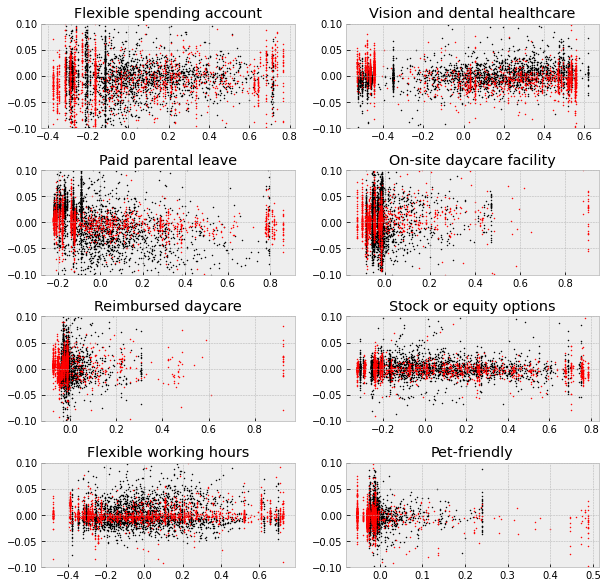

In [99]:
fig, axs = plt.subplots(4,2,figsize=(10,10),squeeze=True)
ind = 0
for ax,var in zip(axs.flat,focus_benfs):
    ax.scatter(x_employee_df[var],shap_values_employee[:,ind],s=1,color='k')
    ax.scatter(x_leadership_df[var],shap_values_leader[:,ind],s=1,color='r')
    ax.set_title(var)
    ax.set_ylim(-0.1,0.1)
    ind+=1
plt.subplots_adjust(hspace=0.4)
plt.savefig('scatter_plots.png')

In [100]:
import statsmodels.api as sm

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


In [101]:
def lowess_with_confidence_bounds(x, y, eval_x, N=10, conf_interval=0.95, subsize=1000, lowess_kw=None):
    """
    Perform Lowess regression and determine a confidence interval by bootstrap resampling
    """

#    smoothed = sm.nonparametric.lowess(exog=x, endog=y, xvals=eval_x, **lowess_kw)

    # Perform bootstrap resamplings of the data
    # and  evaluate the smoothing at a fixed set of points
    smoothed_values = np.empty((N, len(eval_x)))
    temp_x = np.empty(N*subsize)
    temp_y = np.empty(N*subsize)
    j=0
    for i in range(N):
        sample = np.random.choice(len(x), subsize, replace=True)
        sampled_x = x[sample]
        sampled_y = y[sample]
        smoothed_values[i] = sm.nonparametric.lowess(exog=sampled_x, endog=sampled_y, xvals=eval_x, **lowess_kw)
        temp_x[i*subsize:(i+1)*subsize] = sampled_x
        temp_y[i*subsize:(i+1)*subsize] = sampled_y
        print(j,end='\r',flush=True)
        j+=1
        
# Lowess smoothing    
    smoothed = sm.nonparametric.lowess(exog=temp_x, endog=temp_y, xvals=eval_x, **lowess_kw)
    
    # Get the confidence interval
    sorted_values = np.sort(smoothed_values, axis=0)
    bound = int(N * (1 - conf_interval) / 2)
    bottom = sorted_values[bound - 1]
    top = sorted_values[-bound]

    return smoothed, bottom, top

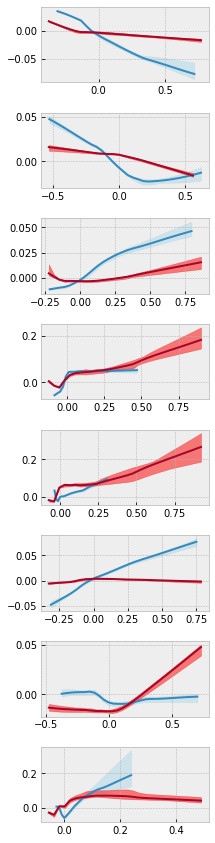

In [102]:
# Single SHAP run
fig, axs = plt.subplots(8,1,figsize=(3,15),squeeze=True)
for ax,var in zip(axs.flat,focus_benfs):
#    sns.regplot(x=x_employee_df[var], y=shap_values_employee_df[var],lowess=False,scatter=False,ax=ax,line_kws={'ls':'--','color':'k'})
#    sns.regplot(x=x_leadership_df[var], y=shap_values_leader_df[var],lowess=False,scatter=False,ax=ax,line_kws={'color':'k'})
    eval_x = np.linspace(np.min(x_employee_df[var]),np.max(x_employee_df[var]),30)
    smoothed, bottom, top = lowess_with_confidence_bounds(x_employee_df[var], shap_values_employee_df[var],
                                                          eval_x, N=10, conf_interval=0.99,lowess_kw={"frac": 0.66})
    ax.plot(eval_x, smoothed)
    ax.fill_between(eval_x, bottom, top, alpha=0.5, color="lightblue")
    eval_x = np.linspace(np.min(x_leadership_df[var]),np.max(x_leadership_df[var]),30)
    smoothed, bottom, top = lowess_with_confidence_bounds(x_leadership_df[var], shap_values_leader_df[var],
                                                          eval_x, N=10, conf_interval=0.99, lowess_kw={"frac": 0.66})
    ax.plot(eval_x, smoothed)
    ax.fill_between(eval_x, bottom, top, alpha=0.5, color="r")
#    ax.set_ylabel(var, rotation=0)
#    ax.yaxis.set_label_coords(-0.35,0.5)
#    ax.set_ylim(-0.1,0.1)
plt.subplots_adjust(hspace=0.4)
plt.savefig('scatter_plots.png')

In [103]:
# With the bootstrap sample

In [104]:
bootstrap_samples_employee_df.reset_index(drop=True,inplace=True)
bootstrap_samples_leader_df.reset_index(drop=True,inplace=True)
bootstrap_shaps_employee_df.reset_index(drop=True,inplace=True)
bootstrap_shaps_leader_df.reset_index(drop=True,inplace=True)

Flexible spending account
Vision and dental healthcare
Paid parental leave
On-site daycare facility
Reimbursed daycare
Stock or equity options
Flexible working hours
Pet-friendly


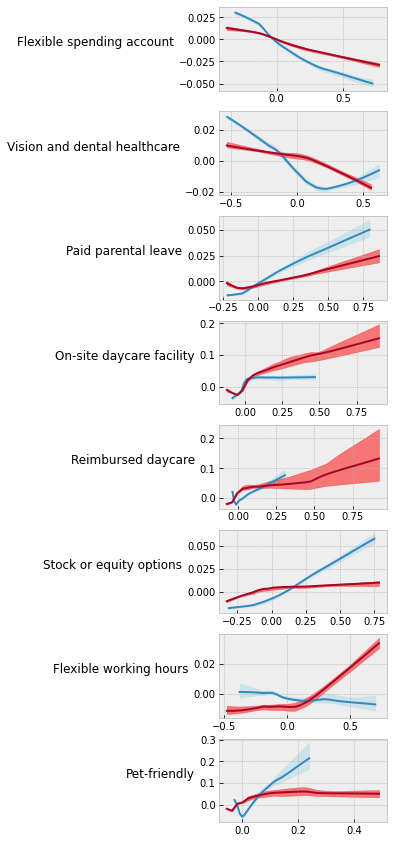

In [105]:
fig, axs = plt.subplots(8,1,figsize=(3,15),squeeze=True)
for ax,var in zip(axs.flat,focus_benfs):
#    sns.regplot(x=x_employee_df[var], y=shap_values_employee_df[var],lowess=False,scatter=False,ax=ax,line_kws={'ls':'--','color':'k'})
#    sns.regplot(x=x_leadership_df[var], y=shap_values_leader_df[var],lowess=False,scatter=False,ax=ax,line_kws={'color':'k'})
    eval_x = np.linspace(np.min(bootstrap_samples_employee_df[var]),np.max(bootstrap_samples_employee_df[var]),30)
    smoothed, bottom, top = lowess_with_confidence_bounds(bootstrap_samples_employee_df[var], bootstrap_shaps_employee_df[var],
                                                          eval_x, N=10, conf_interval=0.95,subsize = 2000,lowess_kw={"frac": 0.66})
    ax.plot(eval_x, smoothed)
    ax.fill_between(eval_x, bottom, top, alpha=0.5, color="lightblue")
    eval_x = np.linspace(np.min(bootstrap_samples_leader_df[var]),np.max(bootstrap_samples_leader_df[var]),30)
    smoothed, bottom, top = lowess_with_confidence_bounds(bootstrap_samples_leader_df[var], bootstrap_shaps_leader_df[var],
                                                          eval_x, N=10, conf_interval=0.95,subsize = 2000, lowess_kw={"frac": 0.66})
    ax.plot(eval_x, smoothed)
    ax.fill_between(eval_x, bottom, top, alpha=0.5, color="r")
    ax.set_ylabel(var, rotation=0, labelpad=5, horizontalalignment='right')
    print(var)
#    ax.set_ylim(-0.1,0.1)
plt.subplots_adjust(hspace=0.25)
#plt.savefig('scatter_plots.png',dpi=150,bbox_inches='tight')

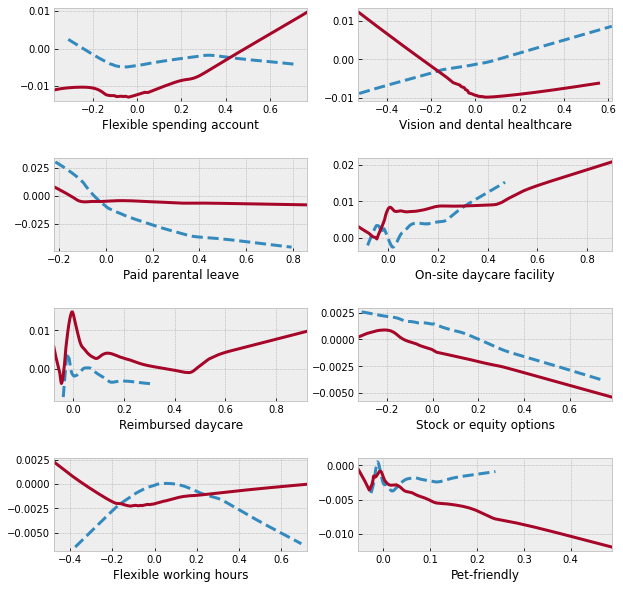

In [106]:
fig, axs = plt.subplots(4,2,figsize=(10,10),squeeze=True)
ind=0
for ax,var in zip(axs.flat,focus_benfs):
    sns.regplot(x=x_employee_df[var], y=shap_values_employee[:,ind],lowess=True,scatter=False,ax=ax,line_kws={'ls':'--'})
    sns.regplot(x=x_leadership_df[var], y=shap_values_leader[:,ind],lowess=True,scatter=False,ax=ax)
#    ax.set_title(var)
#    ax.set_ylim(-0.1,0.1)
    ind+=1
plt.subplots_adjust(hspace=0.6)
plt.savefig('scatter_plots.png')

In [107]:
"""sns.regplot(x=bootstrap_samples_leader_df['Stock or equity options'], y=bootstrap_shaps_leader_df['Stock or equity options'],lowess=True,scatter=False)
sns.regplot(x=bootstrap_samples_employee_df['Stock or equity options'], y=bootstrap_shaps_employee_df['Stock or equity options'],lowess=True,scatter=False)
plt.ylim([-0.2,0.2])"""

"sns.regplot(x=bootstrap_samples_leader_df['Stock or equity options'], y=bootstrap_shaps_leader_df['Stock or equity options'],lowess=True,scatter=False)\nsns.regplot(x=bootstrap_samples_employee_df['Stock or equity options'], y=bootstrap_shaps_employee_df['Stock or equity options'],lowess=True,scatter=False)\nplt.ylim([-0.2,0.2])"

In [108]:
"""sig_table_df = bl.build_sig_table(bootstrap_shaps_employee_df,bootstrap_samples_employee_df,pred_vars,
                                  nobs=2672,no_bins=[-1.,0,1.],conf_limit=0.01,
                                  reset_bins=False,show_limits=False,include_conf_limits=False)"""

'sig_table_df = bl.build_sig_table(bootstrap_shaps_employee_df,bootstrap_samples_employee_df,pred_vars,\n                                  nobs=2672,no_bins=[-1.,0,1.],conf_limit=0.01,\n                                  reset_bins=False,show_limits=False,include_conf_limits=False)'

In [109]:
#sig_table_df

In [110]:
"""sig_table_df = bl.build_sig_table(bootstrap_shaps_leader_df,bootstrap_samples_leader_df,pred_vars,
                                  nobs=2672,no_bins=[-1.,0,1.],conf_limit=0.01,
                                  reset_bins=False,show_limits=False,include_conf_limits=False)"""

'sig_table_df = bl.build_sig_table(bootstrap_shaps_leader_df,bootstrap_samples_leader_df,pred_vars,\n                                  nobs=2672,no_bins=[-1.,0,1.],conf_limit=0.01,\n                                  reset_bins=False,show_limits=False,include_conf_limits=False)'

In [111]:
#sig_table_df

In [83]:
# FOR THE PAPER - LEADER

In [125]:
temp_np = np.mean(np.abs(shap_interactions_lead),axis=0)

In [126]:
for i in range(temp_np.shape[1]):
    temp_np[i,i] = 0

In [127]:
temp_df = pd.DataFrame(temp_np, columns=x_employee_df.columns,index=x_employee_df.columns)

In [130]:
temp_df.loc[focus_benfs,'at'].sort_values(ascending=False).to_clipboard()

In [129]:
temp_df.loc[:,'at'].sort_values(ascending=False)

optvol                                  0.032526
age                                     0.023761
cap_int                                 0.023733
lvg                                     0.023719
rd_int                                  0.022231
sic2dig                                 0.017875
On-site daycare facility                0.009045
Reimbursed daycare                      0.007497
Ability to work remotely                0.006509
401(k)                                  0.006451
Paid time off                           0.006430
Flexible spending account               0.005328
On-site cafeteria                       0.005086
Free snacks and drinks                  0.004595
Flexible working hours                  0.004378
Employee discounts                      0.004107
Vehicle allowance                       0.003889
Pet-friendly                            0.003721
401(k) Company match                    0.003631
Parking                                 0.003549
Relocation allowance

-------

### INTERACTION ASSOCIATIONS

In [112]:
for item in zip(range(0,33),x_employee_df.columns):
    print(item)

(0, '401(k)')
(1, '401(k) Company match')
(2, 'Flexible spending account')
(3, 'Vision and dental healthcare')
(4, 'Relocation allowance')
(5, 'Life insurance')
(6, 'Paid parental leave')
(7, 'Desirable office location')
(8, 'On-site daycare facility')
(9, 'Paid time off')
(10, 'Parking')
(11, 'Reimbursed daycare')
(12, 'Stock or equity options')
(13, 'Ability to work remotely')
(14, 'Easy access to public transportation')
(15, 'Tuition assistance')
(16, 'Flexible working hours')
(17, 'On-site cafeteria')
(18, 'Vehicle allowance')
(19, 'Employee discounts')
(20, 'Pet-friendly')
(21, 'Employee events')
(22, 'Health and wellness programs')
(23, 'On-site fitness center')
(24, 'Free snacks and drinks')
(25, 'Free meals')
(26, 'at')
(27, 'lvg')
(28, 'rd_int')
(29, 'cap_int')
(30, 'optvol')
(31, 'age')
(32, 'sic2dig')


In [113]:
test_data = shap_interactions_emp[x_employee_df['cap_int'] < 1.317,:,:].shape

In [114]:
eval_x = np.linspace(np.min(bootstrap_samples_employee_df[var]),np.max(bootstrap_samples_employee_df[var]),30)
smoothed, bottom, top = lowess_with_confidence_bounds(bootstrap_samples_employee_df[var], bootstrap_shaps_employee_df[var],
                                                          eval_x, N=10, conf_interval=0.95,subsize = 2000,lowess_kw={"frac": 0.66})
ax.plot(eval_x, smoothed)
ax.fill_between(eval_x, bottom, top, alpha=0.5, color="lightblue")
eval_x = np.linspace(np.min(bootstrap_samples_leader_df[var]),np.max(bootstrap_samples_leader_df[var]),30)
smoothed, bottom, top = lowess_with_confidence_bounds(bootstrap_samples_leader_df[var], bootstrap_shaps_leader_df[var],
                                                          eval_x, N=10, conf_interval=0.95,subsize = 2000, lowess_kw={"frac": 0.66})
ax.plot(eval_x, smoothed)
ax.fill_between(eval_x, bottom, top, alpha=0.5, color="r")

Flexible spending account
Vision and dental healthcare
Paid parental leave
On-site daycare facility
Reimbursed daycare
Stock or equity options
Flexible working hours
Pet-friendly


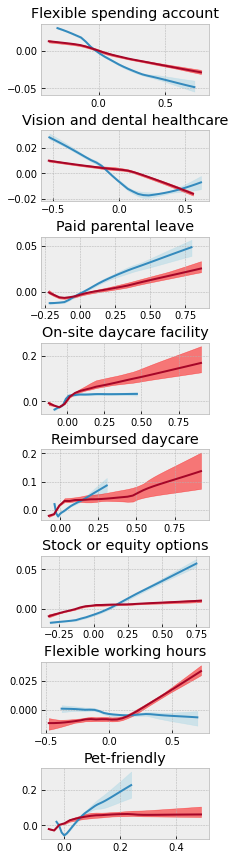

In [115]:
fig, axs = plt.subplots(8,1,figsize=(3,15),squeeze=True)
for ax,var in zip(axs.flat,focus_benfs):
    eval_x = np.linspace(np.min(bootstrap_samples_employee_df[var]),np.max(bootstrap_samples_employee_df[var]),30)
    smoothed, bottom, top = lowess_with_confidence_bounds(bootstrap_samples_employee_df[var], bootstrap_shaps_employee_df[var],
                                                          eval_x, N=10, conf_interval=0.95,subsize = 2000,lowess_kw={"frac": 0.66})
    ax.plot(eval_x, smoothed)
    ax.fill_between(eval_x, bottom, top, alpha=0.5, color="lightblue")
    eval_x = np.linspace(np.min(bootstrap_samples_leader_df[var]),np.max(bootstrap_samples_leader_df[var]),30)
    smoothed, bottom, top = lowess_with_confidence_bounds(bootstrap_samples_leader_df[var], bootstrap_shaps_leader_df[var],
                                                          eval_x, N=10, conf_interval=0.95,subsize = 2000, lowess_kw={"frac": 0.66})
    ax.plot(eval_x, smoothed)
    ax.fill_between(eval_x, bottom, top, alpha=0.5, color="r")
    ax.set_title(var)
    print(var)
#    ax.set_ylim(-0.1,0.1)
plt.subplots_adjust(hspace=0.5)

In [116]:
# NEW EXPERIMENTS

In [117]:
for item in zip(range(0,33),x_employee_df.columns):
    print(item)

(0, '401(k)')
(1, '401(k) Company match')
(2, 'Flexible spending account')
(3, 'Vision and dental healthcare')
(4, 'Relocation allowance')
(5, 'Life insurance')
(6, 'Paid parental leave')
(7, 'Desirable office location')
(8, 'On-site daycare facility')
(9, 'Paid time off')
(10, 'Parking')
(11, 'Reimbursed daycare')
(12, 'Stock or equity options')
(13, 'Ability to work remotely')
(14, 'Easy access to public transportation')
(15, 'Tuition assistance')
(16, 'Flexible working hours')
(17, 'On-site cafeteria')
(18, 'Vehicle allowance')
(19, 'Employee discounts')
(20, 'Pet-friendly')
(21, 'Employee events')
(22, 'Health and wellness programs')
(23, 'On-site fitness center')
(24, 'Free snacks and drinks')
(25, 'Free meals')
(26, 'at')
(27, 'lvg')
(28, 'rd_int')
(29, 'cap_int')
(30, 'optvol')
(31, 'age')
(32, 'sic2dig')


In [118]:
from scipy import stats

In [119]:
results = stats.binned_statistic_2d(x_employee_df.dropna().iloc[:,2],x_employee_df.dropna().iloc[:,29],
                                    shap_interactions_emp[x_employee_df.dropna().index,29,2],bins=6)

In [120]:
points_x=[]
for i in range(len(results.x_edge)-1):
    points_x.append((results.x_edge[i]+results.x_edge[i+1])/2)
points_y=[]
for i in range(len(results.y_edge)-1):
    points_y.append((results.y_edge[i]+results.y_edge[i+1])/2)

In [121]:
test_df = pd.DataFrame(results.statistic,index=points_y,columns=points_x)

In [122]:
test_df.index = np.around(test_df.index,2)

In [123]:
test_df.columns = np.around(test_df.columns,2)

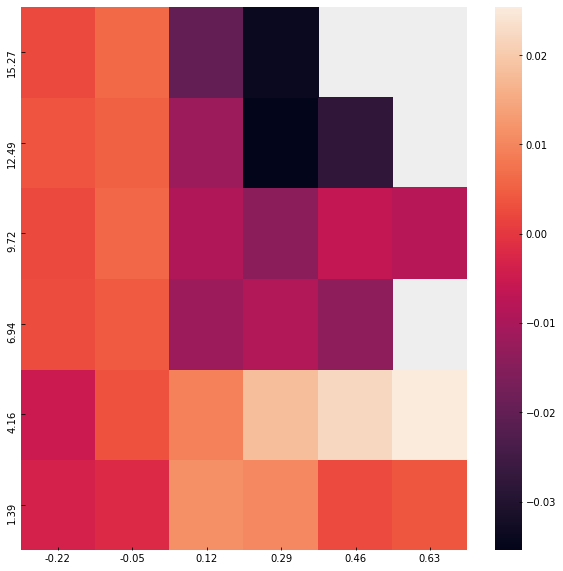

In [124]:
fig, ax = plt.subplots(figsize=(10,10))

sns.heatmap(test_df,ax=ax)

ax.invert_yaxis()

## Employees

In [125]:
from scipy.interpolate import griddata

In [126]:
# Focus benf locations: 2, 3, 6, 8, 11, 12, 16, 20
x_index = 26
y_index = 20
y_name = 'Total assets'

In [127]:
# Interpolation points
x = np.linspace(min(x_employee_df.iloc[:,x_index]),max(x_employee_df.iloc[:,x_index]),15)
y =  np.linspace(min(x_employee_df.iloc[:,y_index]),max(x_employee_df.iloc[:,y_index]),15)
X, Y = np.meshgrid(x,y)

In [128]:
Ti = griddata((x_employee_df.dropna().iloc[:,x_index],x_employee_df.dropna().iloc[:,y_index]),
              shap_interactions_emp[x_employee_df.dropna().index,x_index,y_index],(X,Y),
              fill_value=np.mean(shap_interactions_emp[x_employee_df.dropna().index,x_index,y_index]),method='linear')

In [129]:
from mpl_toolkits import mplot3d

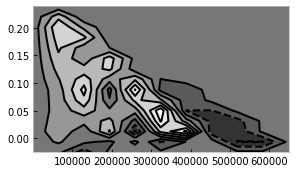

In [130]:
fig1, ax = plt.subplots(constrained_layout=True,figsize=(4.,2.3))
#fig1, ax = plt.subplots(constrained_layout=True,figsize=(5,5))
plt.grid(False)
CS = ax.contourf(X,Y,Ti,cmap='Greys_r',extend='neither')
ax.contour(X,Y,Ti,colors='k')
#fig1.colorbar(CS)
#ax.set_ylabel(x_employee_df.columns[y_index],rotation=0,labelpad=0,horizontalalignment='right')
#ax.set_ylabel(y_name)
#ax.tick_params(labelbottom=False)
ax.set_xlim(right=650000)
#ax.set_title('Tobin\'s Q')
plt.savefig('Employee_Tobin\'s Q_' + x_employee_df.columns[y_index] + '_' + y_name + '_' + 'inter_heatmap.png',dpi=150)
plt.show()

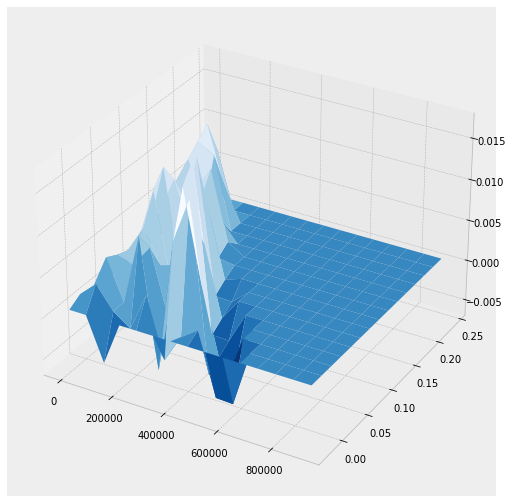

In [131]:
fig = plt.figure(figsize =(14, 9))
ax = plt.axes(projection ='3d')
ax.plot_surface(X,Y,Ti,cmap='Blues_r', antialiased=True)

In [132]:
for item in zip(range(0,33),x_employee_df.columns):
    print(item)

(0, '401(k)')
(1, '401(k) Company match')
(2, 'Flexible spending account')
(3, 'Vision and dental healthcare')
(4, 'Relocation allowance')
(5, 'Life insurance')
(6, 'Paid parental leave')
(7, 'Desirable office location')
(8, 'On-site daycare facility')
(9, 'Paid time off')
(10, 'Parking')
(11, 'Reimbursed daycare')
(12, 'Stock or equity options')
(13, 'Ability to work remotely')
(14, 'Easy access to public transportation')
(15, 'Tuition assistance')
(16, 'Flexible working hours')
(17, 'On-site cafeteria')
(18, 'Vehicle allowance')
(19, 'Employee discounts')
(20, 'Pet-friendly')
(21, 'Employee events')
(22, 'Health and wellness programs')
(23, 'On-site fitness center')
(24, 'Free snacks and drinks')
(25, 'Free meals')
(26, 'at')
(27, 'lvg')
(28, 'rd_int')
(29, 'cap_int')
(30, 'optvol')
(31, 'age')
(32, 'sic2dig')


## Leaders

In [133]:
from scipy.interpolate import griddata

In [199]:
# Focus benf locations: 2, 3, 6, 8, 11, 12, 16, 20
x_index = 26
y_index = 20
y_name = 'Total assets'

In [200]:
# Interpolation points
x = np.linspace(min(x_leadership_df.iloc[:,x_index]),max(x_leadership_df.iloc[:,x_index]),18)
y =  np.linspace(min(x_leadership_df.iloc[:,y_index]),max(x_leadership_df.iloc[:,y_index]),18)
X, Y = np.meshgrid(x,y)

In [201]:
Ti = griddata((x_leadership_df.dropna().iloc[:,x_index],x_leadership_df.dropna().iloc[:,y_index]),
              shap_interactions_lead[x_leadership_df.dropna().index,x_index,y_index],(X,Y),
              fill_value=np.mean(shap_interactions_lead[x_leadership_df.dropna().index,x_index,y_index]),method='linear')

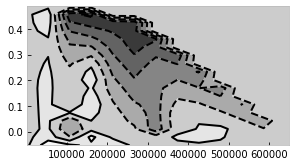

In [203]:
fig1, ax = plt.subplots(constrained_layout=True,figsize=(4.,2.2))
plt.grid(False)
CS = ax.contourf(X,Y,Ti,cmap='Greys_r',extend='neither')
ax.contour(X,Y,Ti,colors='k')
#fig1.colorbar(CS)
#ax.set_xlabel(x_leadership_df.columns[x_index])
#ax.set_ylabel(y_name)
#ax.set_title('Tobin\'s Q')
#ax.tick_params(labelbottom=False)
ax.set_xlim(right=650000)
#ax.set_xlim(right=0.5)
plt.savefig('Leader_Tobin\'s Q_' + x_leadership_df.columns[y_index] + '_' + y_name + '_' + 'inter_heatmap.png',dpi=150)
plt.show()

### TESTING 

In [37]:
# rank-and-file vs. management

In [56]:
x_employee_df+1

,401(k),401(k) Company match,Flexible spending account,Vision and dental healthcare,Relocation allowance,Life insurance,Paid parental leave,Desirable office location,On-site daycare facility,Paid time off,...,On-site fitness center,Free snacks and drinks,Free meals,at,lvg,rd_int,cap_int,optvol,age,sic2dig
0,0.974562,0.542053,0.706765,0.475262,0.951182,0.512858,0.834312,0.865928,0.969680,0.520899,...,0.873092,0.996517,0.921620,31270.0,1.526051,6.660558,5.774697,21.8,769,27
1,1.149165,0.542053,0.706765,0.475262,0.951182,0.512858,0.834312,0.865928,1.080791,0.520899,...,0.873092,0.925088,0.921620,32719.0,1.926119,6.388471,5.465432,21.1,781,27
2,1.060277,1.258719,1.298432,1.283595,1.117848,1.337858,0.984312,1.207595,0.969680,1.387566,...,1.039759,1.266755,1.329953,32907.0,2.135657,6.272595,5.315322,21.8,793,27
3,1.155393,1.341720,1.227298,1.390356,1.087697,1.378562,1.313780,1.028525,1.027393,1.356082,...,1.180528,0.968096,0.949922,37988.0,2.211537,5.870087,4.614394,18.3,805,27
4,0.840764,0.846931,0.865302,0.967945,0.951182,0.993345,1.129434,1.012270,0.981875,0.925777,...,0.995043,0.987283,1.021620,36501.0,2.500306,5.989041,5.320548,22.0,817,27
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,27220.5,2.168731,1.987527,2.594813,23.2,169,39
2668,1.279603,1.417011,1.022948,1.317154,1.458900,1.379043,1.476356,1.009369,0.915897,1.498347,...,1.292445,0.979539,0.892797,26685.4,2.162635,2.482514,2.986929,22.9,181,39
2669,0.862937,1.417011,1.272948,1.317154,0.955473,1.212377,1.143023,1.092702,0.915897,1.165014,...,0.959112,0.896206,0.892797,25965.5,1.864236,2.487416,2.898746,22.6,193,39
2670,1.065318,1.269392,1.132472,1.269535,1.055473,1.159996,1.152547,1.014130,0.915897,1.184061,...,1.235302,0.946206,0.992797,24127.8,1.793050,2.639256,2.819553,23.1,205,39


In [39]:
x_leadership_df

,401(k),401(k) Company match,Flexible spending account,Vision and dental healthcare,Relocation allowance,Life insurance,Paid parental leave,Desirable office location,On-site daycare facility,Paid time off,...,On-site fitness center,Free snacks and drinks,Free meals,at,lvg,rd_int,cap_int,optvol,age,sic2dig
0,0.244763,-0.485437,-0.356036,-0.477360,-0.128670,-0.453905,-0.179413,-0.152965,-0.045063,-0.433863,...,-0.168221,-0.092522,-0.097312,31269.0,0.526051,5.660558,4.774697,20.8,768,26
1,0.244763,-0.485437,-0.356036,-0.477360,-0.128670,-0.453905,-0.179413,-0.152965,-0.045063,-0.433863,...,-0.168221,-0.092522,-0.097312,32718.0,0.926119,5.388471,4.465432,20.1,780,26
2,-0.255237,0.264563,0.143964,0.272640,0.121330,-0.203905,0.070587,-0.152965,-0.045063,0.066137,...,0.331779,0.032478,-0.097312,32906.0,1.135657,5.272595,4.315322,20.8,792,26
3,0.044763,0.331230,0.127298,0.289307,0.337996,0.362762,0.303920,0.247035,0.054937,0.466137,...,0.215113,0.090812,0.219355,37987.0,1.211537,4.870087,3.614394,17.3,804,26
4,-0.005237,0.264563,0.143964,0.272640,-0.128670,0.296095,0.320587,0.347035,-0.045063,0.316137,...,-0.168221,0.032478,0.152688,36500.0,1.500306,4.989041,4.320548,21.0,816,26
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2667,0.200728,-0.443772,-0.375393,-0.528893,-0.058506,-0.473972,-0.192480,-0.233108,-0.100224,-0.493409,...,-0.188040,-0.107276,-0.123334,27219.5,1.168731,0.987527,1.594813,22.2,168,38
2668,0.200728,0.556228,0.624607,0.471107,0.441494,0.526028,0.307520,0.266892,-0.100224,0.506591,...,0.311960,-0.107276,-0.123334,26684.4,1.162635,1.482514,1.986929,21.9,180,38
2669,0.200728,-0.443772,-0.375393,0.471107,-0.058506,0.526028,-0.192480,-0.233108,-0.100224,0.506591,...,0.811960,-0.107276,-0.123334,25964.5,0.864236,1.487416,1.898746,21.6,192,38
2670,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,24126.8,0.793050,1.639256,1.819553,22.1,204,38


In [60]:
temp_df = np.abs(1-(x_leadership_df+1)-(x_employee_df+1))*(x_employee_df+1)*(x_leadership_df+1)

In [63]:
temp_df.describe().loc['mean'].sort_values()[0:26]

Pet-friendly                            1.004814
Reimbursed daycare                      1.020263
On-site daycare facility                1.034745
Vehicle allowance                       1.046065
Free snacks and drinks                  1.054068
Relocation allowance                    1.063742
Desirable office location               1.115804
Easy access to public transportation    1.126236
Free meals                              1.127112
Ability to work remotely                1.158408
On-site fitness center                  1.162283
Paid parental leave                     1.163934
Parking                                 1.199788
401(k)                                  1.205327
Health and wellness programs            1.217564
Flexible working hours                  1.219888
On-site cafeteria                       1.267301
Employee discounts                      1.274791
Tuition assistance                      1.294063
Employee events                         1.297729
Stock or equity opti

In [59]:
x_employee_df.describe()

,401(k),401(k) Company match,Flexible spending account,Vision and dental healthcare,Relocation allowance,Life insurance,Paid parental leave,Desirable office location,On-site daycare facility,Paid time off,...,On-site fitness center,Free snacks and drinks,Free meals,at,lvg,rd_int,cap_int,optvol,age,sic2dig
count,2507.000000,2507.000000,2507.000000,2507.000000,2507.000000,2507.000000,2507.000000,2507.000000,2507.000000,2507.000000,...,2507.000000,2507.000000,2507.000000,2672.000000,2661.000000,1503.000000,2670.000000,1588.000000,2672.000000,2672.000000
mean,0.000169,-0.000627,-0.000669,-0.000329,-0.001830,-0.001012,-0.000345,-0.000499,-0.002720,-0.000541,...,-0.000638,-0.002121,-0.001732,55366.946411,1.196609,2.265516,3.887994,29.234109,403.598428,50.164296
std,0.257198,0.327839,0.252467,0.362583,0.091868,0.335081,0.208675,0.191145,0.089163,0.356922,...,0.211656,0.120364,0.159749,135112.779348,4.754539,3.675849,3.476118,9.400973,225.960856,18.411585
min,-0.707976,-0.457947,-0.310385,-0.524738,-0.103801,-0.487142,-0.217390,-0.220135,-0.084103,-0.501653,...,-0.239300,-0.132963,-0.166409,425.996390,-21.320357,0.000000,0.000000,14.400000,12.000000,1.000000
25%,-0.174874,-0.358861,-0.206139,-0.348529,-0.044527,-0.362963,-0.157800,-0.134072,-0.045459,-0.326881,...,-0.137218,-0.091296,-0.094881,4020.227250,0.346285,0.000000,1.317301,22.700000,228.000000,35.000000
50%,0.028378,-0.008430,-0.064255,0.063128,-0.028559,0.013446,-0.070831,-0.053468,-0.016390,0.042253,...,-0.048092,-0.041294,-0.073899,12084.000000,0.750827,0.692120,2.996903,27.500000,372.000000,51.000000
75%,0.211431,0.269580,0.148269,0.312015,-0.021545,0.277032,0.084312,0.067329,-0.012108,0.302060,...,0.051892,0.045609,0.046382,39180.735000,1.489183,2.854180,5.382990,34.100000,576.000000,63.000000
max,0.491793,0.641139,0.718804,0.617138,0.458900,0.590901,0.794606,0.778110,0.469564,0.612400,...,0.792445,0.424889,0.670804,906524.310000,29.273304,19.020519,16.659777,58.765000,828.000000,99.000000
